# tfmplayground.priors Visualization and Demo Notebook

This notebook shows how to generate, load, and visualize synthetic tabular data using the `tfmplayground.priors` package. You’ll see examples for both regression and classification, using different types of priors, with clear visualizations to help you explore the data.

## Contents:

1. **TICL MLP Prior Regression** - Visualizing regression data generated from MLP prior
2. **TICL GP Prior Regression** - Visualizing regression data from Gaussian Process prior
3. **TabICL Classification** - Visualizing classification data from TabICL prior
4. **Live Data Generation** - Generating and visualizing synthetic data in real-time

## Prerequisites:

- Ensure you have the tfmplayground package installed
- Run the necessary commands to generate the HDF5 data files as shown in each section

We first create some helper functions for the visualizations, you can skip these and continue reading after this cell.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tfmplayground.priors.dataloader import PriorDumpDataLoader

def plot_regression_samples(X_data, y_data, title, batch_size=4):
    """Plot regression feature-target relationships."""
    num_features = X_data.shape[2]
    
    if num_features == 1:
        _plot_regression_1d(X_data, y_data, title, batch_size)
    else:
        _plot_regression_2d(X_data, y_data, title, batch_size, num_features)

def _plot_regression_1d(X_data, y_data, title, batch_size):
    """Plot 1D regression samples."""
    rows, cols = 4, 5
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    axes = axes.flatten()
    for i in range(batch_size):
        X_i = X_data[i, :, 0]
        y_i = y_data[i, :]
        axes[i].scatter(X_i, y_i, color='blue', alpha=0.7, s=20)
        axes[i].set_title(f"Sample {i + 1}")
        axes[i].set_xlabel("x")
        axes[i].set_ylabel("y")
    for i in range(batch_size, len(axes)):
        fig.delaxes(axes[i])
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def _plot_regression_2d(X_data, y_data, title, batch_size, num_features):
    """Plot 2D regression with color gradients and statistics."""
    print(f"Data shape: {X_data.shape}, Features: {num_features}")
    print(f"Target range: [{y_data.min():.3f}, {y_data.max():.3f}]")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i in range(min(batch_size, 4)):
        ax = axes[i]
        X_i = X_data[i, :, :2]  # Use first 2 features
        y_i = y_data[i, :]
        
        # Scatter plot with color gradient
        scatter = ax.scatter(X_i[:, 0], X_i[:, 1], c=y_i, cmap='viridis', 
                           alpha=0.7, s=40, edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title(f'Sample {i + 1} (Range: {y_i.min():.2f}-{y_i.max():.2f})')
        ax.grid(True, alpha=0.3)

        plt.colorbar(scatter, ax=ax, shrink=0.8)
    
    for i in range(batch_size, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(f"{title} - Feature Space", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_classification_samples(X_data, y_data, title, batch_size=4):
    """Plot 2D classification samples with class distributions."""
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00', '#984ea3']
    
    # Print class distribution
    all_classes = np.unique(y_data.flatten())
    print(f"Classes found: {all_classes}")
    for cls in all_classes:
        count = np.sum(y_data == cls)
        percentage = count / y_data.size * 100
        print(f"  Class {cls}: {count} points ({percentage:.1f}%)")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i in range(min(batch_size, 4)):
        ax = axes[i]
        X_i = X_data[i, :, :2]  # Use first 2 features
        y_i = y_data[i, :].astype(int)
        
        unique_classes = np.unique(y_i)
        
        for class_idx in unique_classes:
            mask = (y_i == class_idx)
            if np.any(mask):
                color = colors[class_idx % len(colors)]
                count = np.sum(mask)
                ax.scatter(X_i[mask, 0], X_i[mask, 1],
                          color=color, alpha=0.8, s=60,
                          label=f'C{class_idx} ({count})')
                
                # Mark class centroid
                centroid = np.mean(X_i[mask, :2], axis=0)
                ax.scatter(centroid[0], centroid[1],
                          color=color, s=100, marker='X', alpha=1.0)
        
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_title(f"Sample {i + 1} ({len(unique_classes)} classes)")
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
    
    for i in range(batch_size, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(f"{title} - Classification", fontsize=14)
    plt.tight_layout()
    plt.show()

def load_and_print_info(loader_or_path, loader_type="dump"):
    """Load data and print basic information."""
    if loader_type == "dump":
        if isinstance(loader_or_path, str):
            loader = PriorDumpDataLoader(
                filename=loader_or_path, 
                num_steps=1, 
                batch_size=20, 
                device='cpu'
            )
        else:
            loader = loader_or_path
    else:
        loader = loader_or_path
    
    batch = next(iter(loader))
    X_data = batch["x"].cpu().numpy()
    y_data = batch["y"].cpu().numpy()
    
    print(f"Data shape: X={X_data.shape}, y={y_data.shape}")
    print(f"Eval position: {batch['single_eval_pos']}")
    
    return X_data, y_data, batch

## 1. TICL MLP Prior for Regression

This section loads regression data generated from MLP (Multi-Layer Perceptron) priors. The visualizations show:
- **Feature Space plots**: 2D scatter plots where each point represents a data sample, with colors indicating the target values (regression outputs)

You can create the data file for this section with:

In [2]:
!python -m tfmplayground.priors --lib ticl --prior_type mlp --num_batches 1 --batch_size 4 --max_features 2 --max_seq_len 1000 --np_seed 0 --torch_seed 0

Finished iteration over all stored datasets! Will start reusing the same data with different splits now.
Data shape: X=(4, 1000, 2), y=(4, 1000)
Eval position: 694
Data shape: (4, 1000, 2), Features: 2
Target range: [-17.730, 8.475]


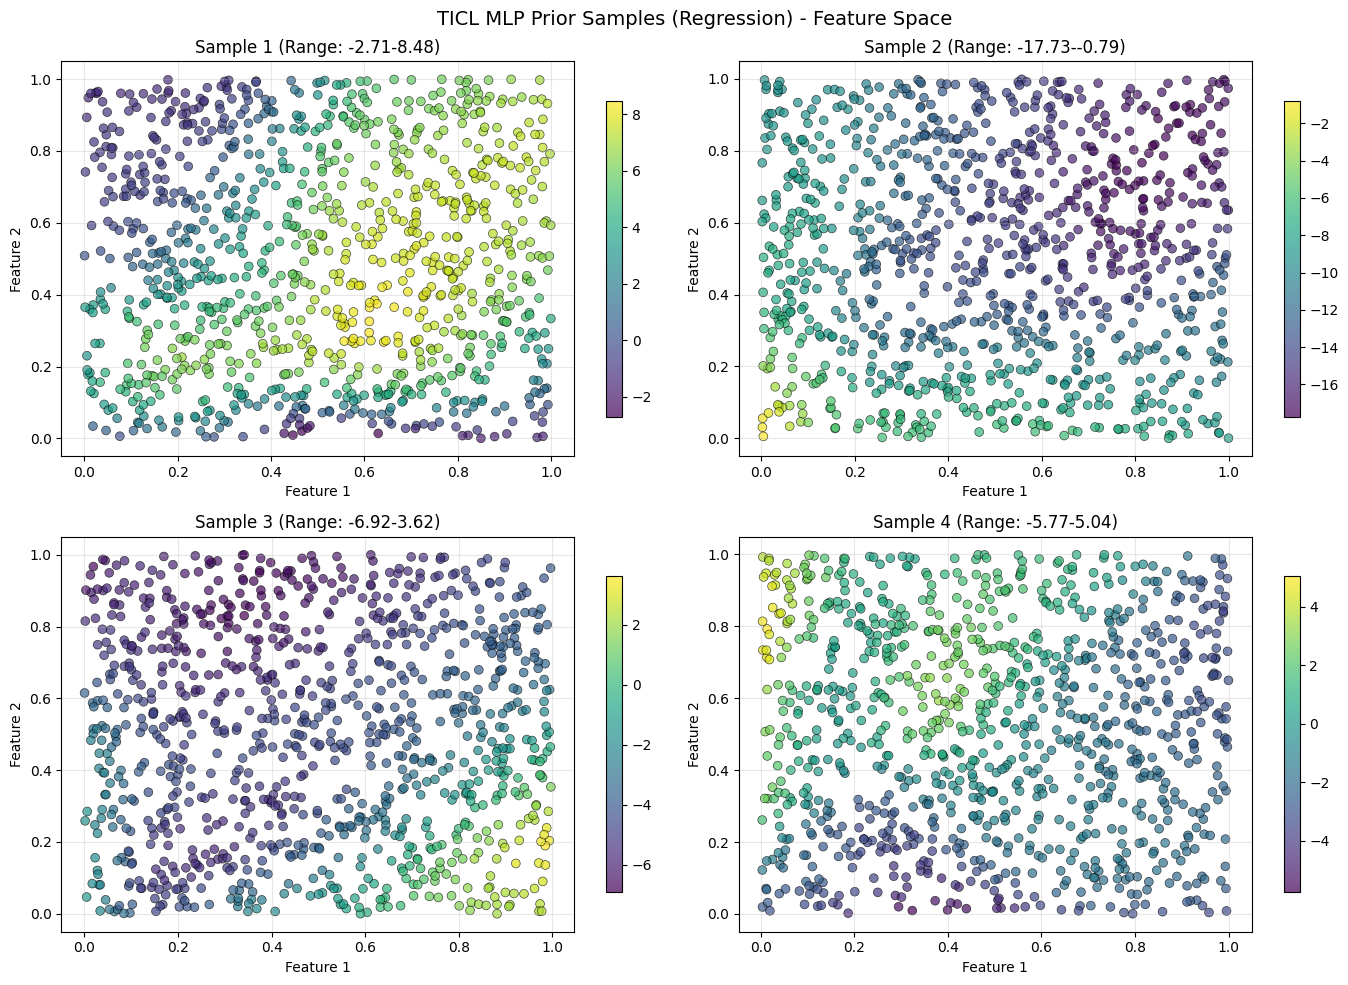

In [3]:
# Load and visualize TICL MLP prior data
path_to_dump = "prior_ticl_mlp_1x4_1000x2.h5"

X_all, y_all, batch = load_and_print_info(path_to_dump)

plot_regression_samples(
    X_data=X_all, 
    y_data=y_all, 
    title="TICL MLP Prior Samples (Regression)"
)

## 2. TICL GP Prior for Regression

This section loads regression data generated from Gaussian Process priors. The visualizations show:
- **Feature Space plots**: 2D scatter plots where each point represents a data sample, with colors indicating the target values (regression outputs) 
- GP priors tend to produce smoother, more correlated patterns compared to MLP priors

You can create the data file for this section with:

In [4]:
!python -m tfmplayground.priors --lib ticl --prior_type gp --num_batches 1 --batch_size 4 --max_features 2 --max_seq_len 1000 --np_seed 0 --torch_seed 0

Finished iteration over all stored datasets! Will start reusing the same data with different splits now.
Data shape: X=(4, 1000, 2), y=(4, 1000)
Eval position: 694
Data shape: (4, 1000, 2), Features: 2
Target range: [-2.585, 2.281]


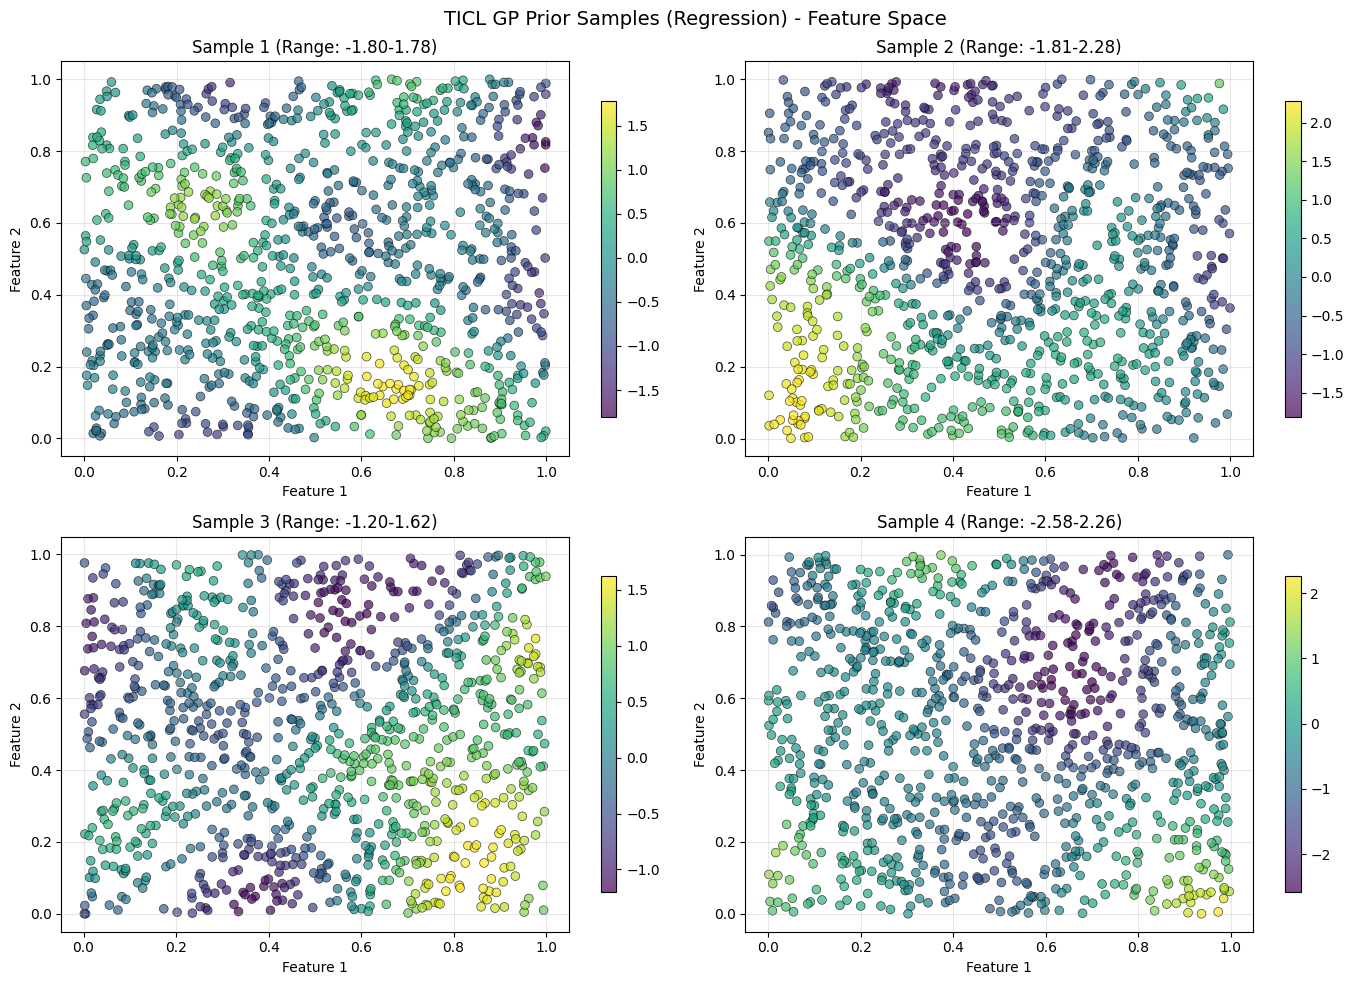

In [5]:
# Load and visualize TICL GP prior data
path_to_gp_dump = "prior_ticl_gp_1x4_1000x2.h5"

X_gp, y_gp, gp_batch = load_and_print_info(path_to_gp_dump)

plot_regression_samples(
    X_data=X_gp, 
    y_data=y_gp, 
    title="TICL GP Prior Samples (Regression)"
)

## 3. TabICL Prior for Classification

This section loads classification data from TabICL priors. The visualizations show:
- **2D scatter plots** in feature space where each point represents a data sample, colored by its class label
- **Class centroids** marked with 'X' symbols showing the center of each class cluster
- **Class distribution statistics** printed above the plots, showing how many points belong to each class
- Each sample can have different numbers of classes (2-4 classes shown), demonstrating the flexibility of TabICL priors

You can create the data file for this section with:

In [6]:
!python -m tfmplayground.priors --lib tabicl --num_batches 1 --batch_size 4 --min_features 2 --max_features 2 --max_seq_len 50 --max_classes 5 --np_seed 0 --torch_seed 0

Finished iteration over all stored datasets! Will start reusing the same data with different splits now.
Data shape: X=(4, 50, 2), y=(4, 50)
Eval position: 26
Classes found: [0. 1. 2.]
  Class 0.0: 75 points (37.5%)
  Class 1.0: 123 points (61.5%)
  Class 2.0: 2 points (1.0%)


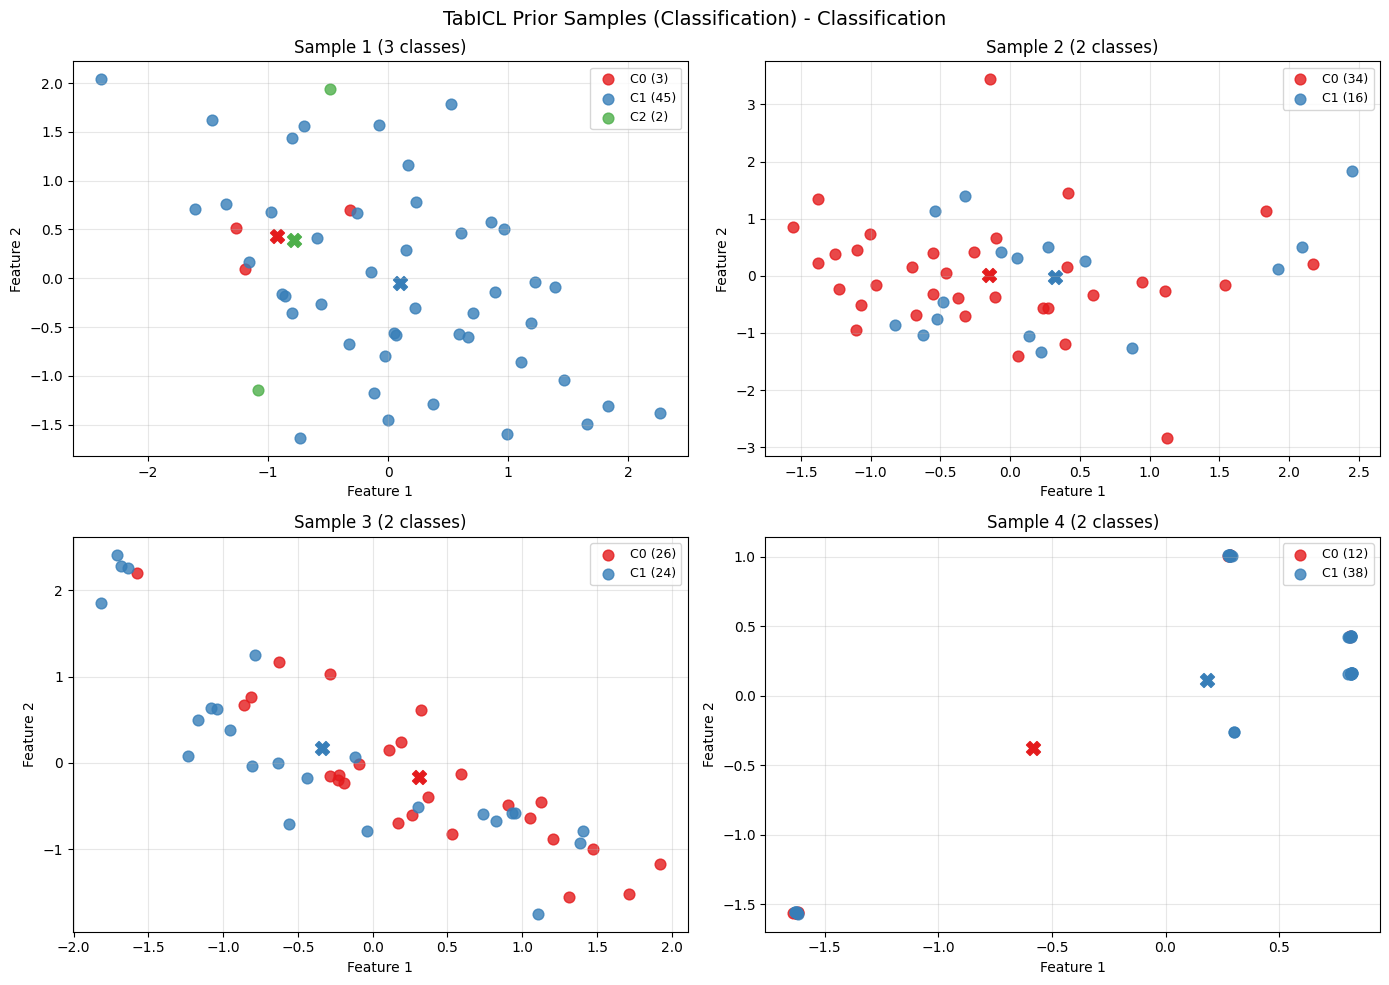

In [7]:
# Load and visualize TabICL classification data
path_to_tabicl_dump = "prior_tabicl_1x4_50x2.h5"

X_tabicl, y_tabicl, tabicl_batch = load_and_print_info(path_to_tabicl_dump)

plot_classification_samples(
    X_data=X_tabicl, 
    y_data=y_tabicl, 
    title="TabICL Prior Samples (Classification)"
)

## 4. Live Data Generation (Real-time Synthesis)

This section demonstrates generating synthetic data on-the-fly using data loaders instead of loading from pre-generated HDF5 files. 
This approach is useful for:
- **Experimenting** with different prior configurations without saving intermediate files
- **Testing parameter sensitivity** by easily changing data generation parameters
- **Immediate visualization** and analysis without file I/O overhead
- **Interactive exploration** during development and research
- **Limited Disk Space** 

### 4.1 Live TICL MLP Regression Data

Data shape: X=(20, 50, 1), y=(20, 50)
Eval position: 10


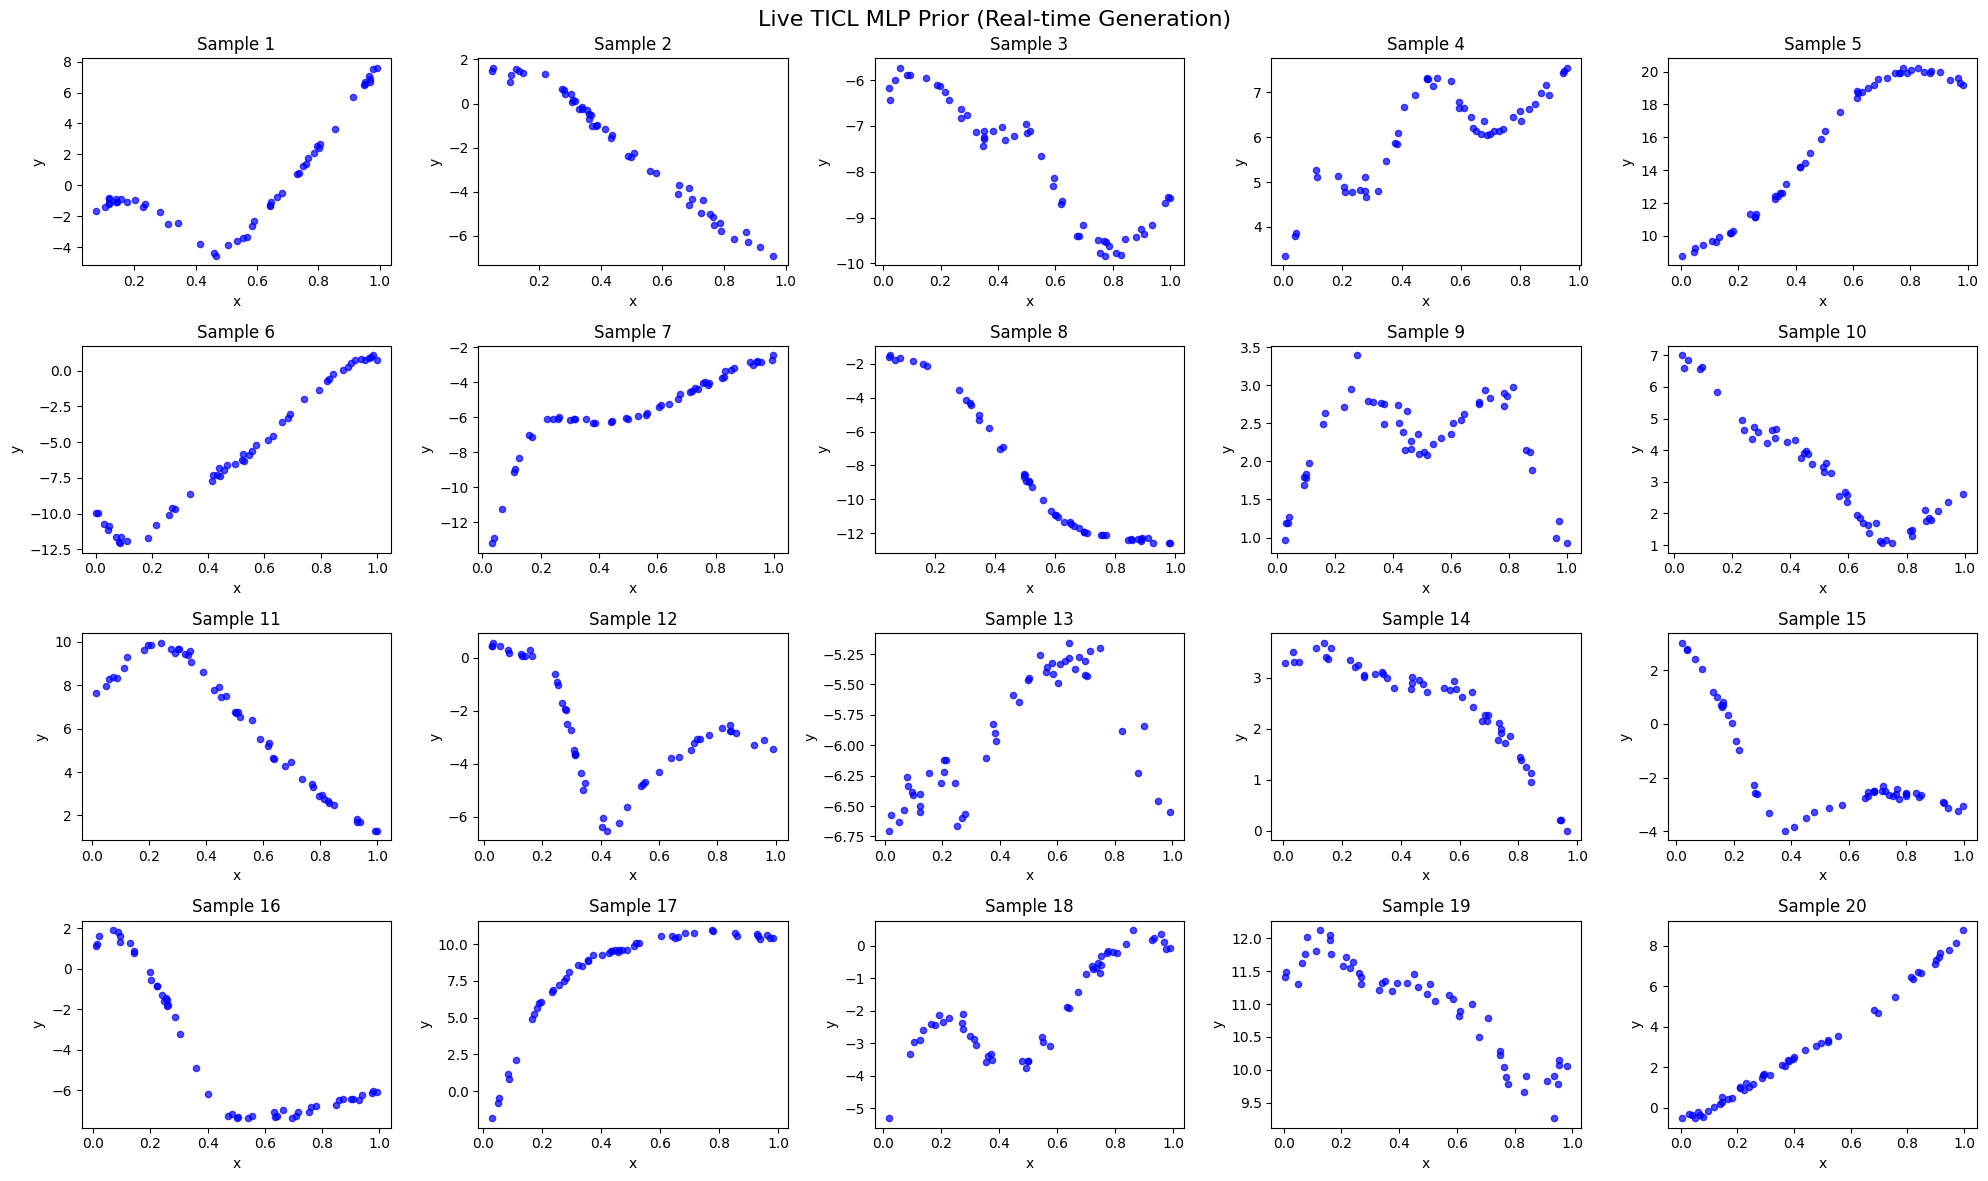

In [8]:
# Live TICL MLP data generation
from tfmplayground.priors.dataloader import TICLPriorDataLoader
from tfmplayground.priors.utils import build_ticl_prior
import torch

device = torch.device('cpu')
np.random.seed(0)
torch.manual_seed(0)

# Create and use live TICL MLP loader
ticl_mlp_loader = TICLPriorDataLoader(
    prior=build_ticl_prior('mlp'),
    num_steps=1,
    batch_size=20,
    num_datapoints_max=50,
    num_features=1,
    device=device,
    min_eval_pos=10
)

X_live_mlp, y_live_mlp, _ = load_and_print_info(ticl_mlp_loader, "live")

plot_regression_samples(
    X_data=X_live_mlp, 
    y_data=y_live_mlp, 
    title="Live TICL MLP Prior (Real-time Generation)",
    batch_size=X_live_mlp.shape[0]
)

### 4.2 Live TICL GP Regression Data

Data shape: X=(20, 50, 1), y=(20, 50)
Eval position: 10


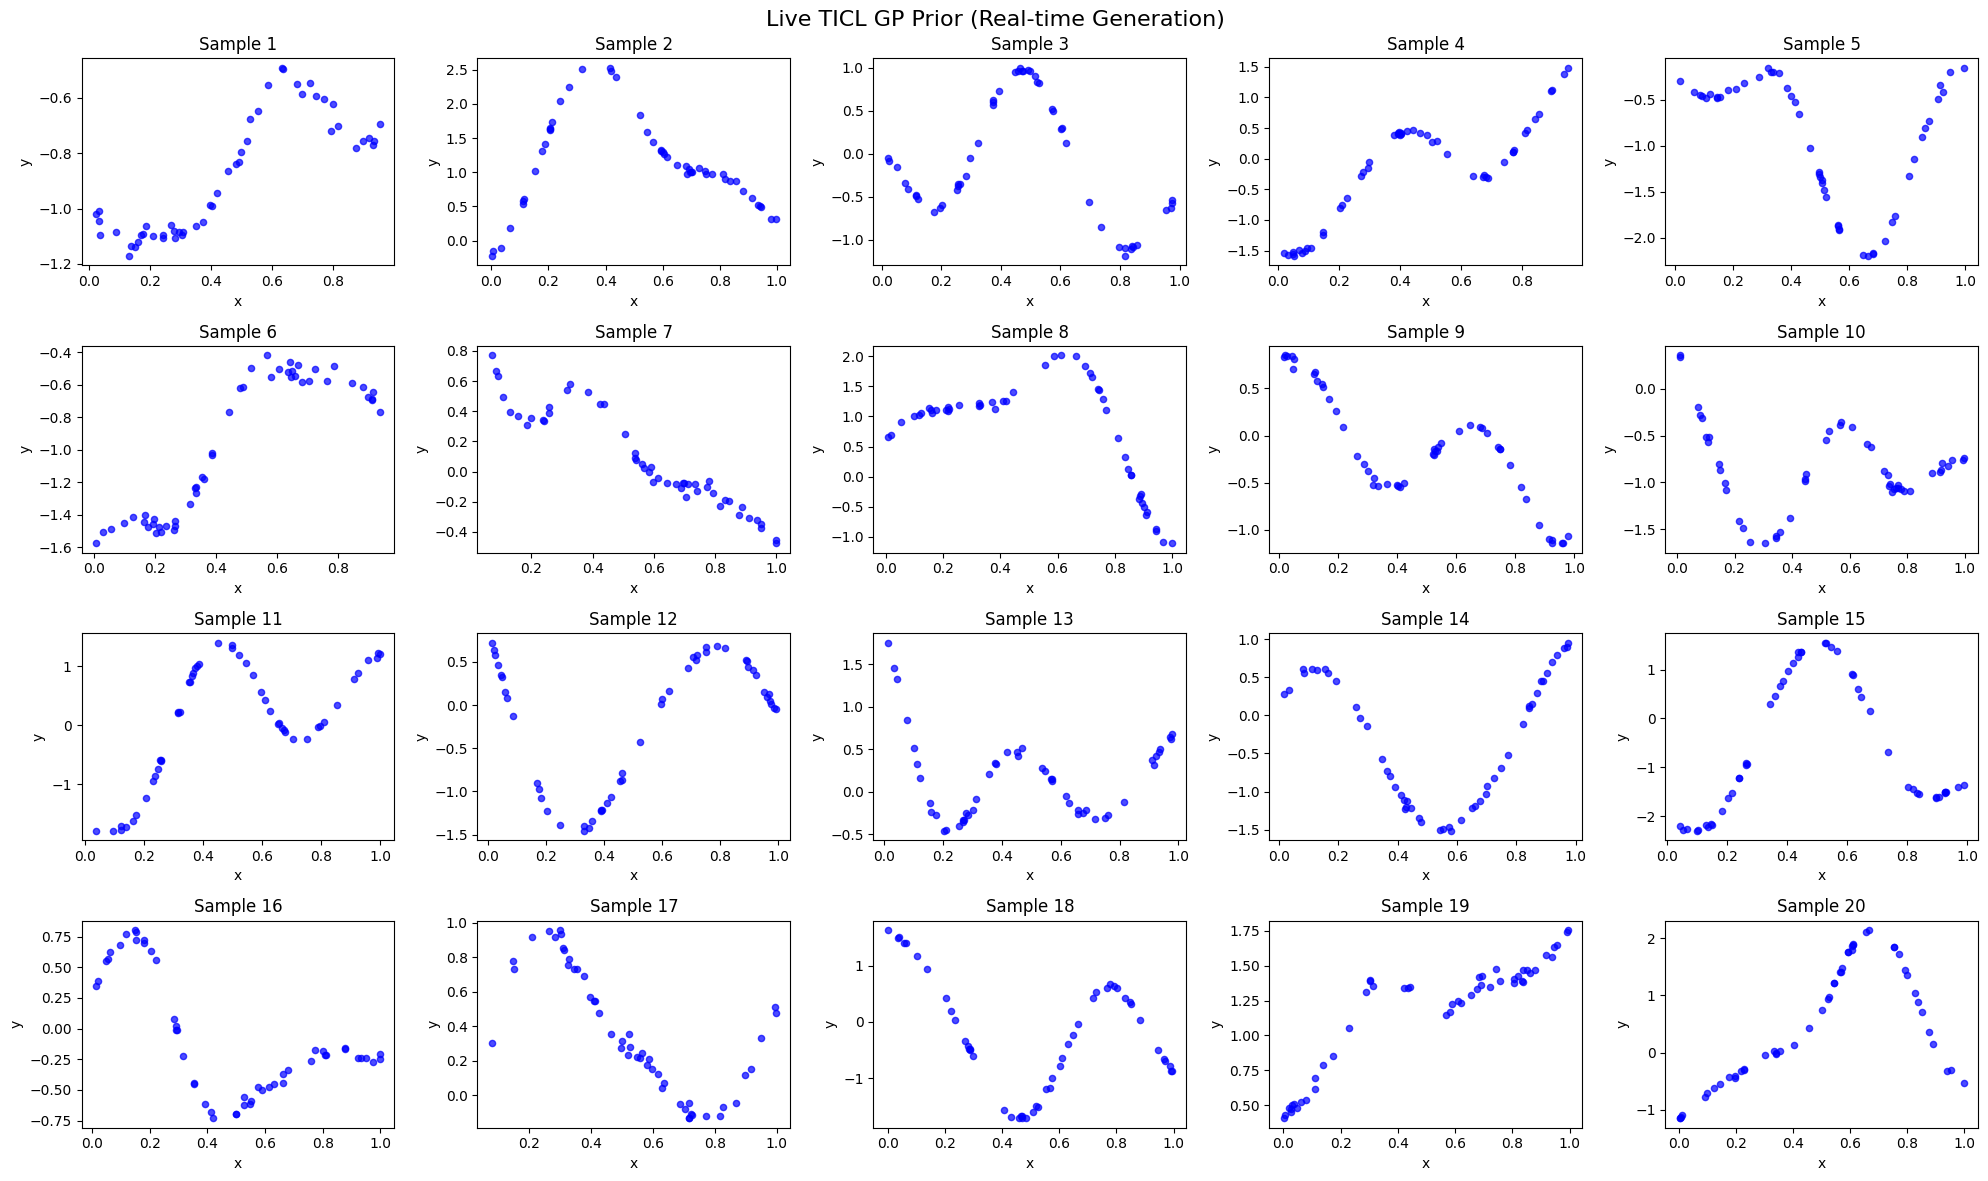

In [9]:
np.random.seed(0)
torch.manual_seed(0)
# Live TICL GP data generation
ticl_gp_loader = TICLPriorDataLoader(
    prior=build_ticl_prior('gp'),
    num_steps=1,
    batch_size=20,
    num_datapoints_max=50,
    num_features=1,
    device=device,
    min_eval_pos=10,
)

X_live_gp, y_live_gp, _ = load_and_print_info(ticl_gp_loader, "live")

plot_regression_samples(
    X_data=X_live_gp, 
    y_data=y_live_gp, 
    title="Live TICL GP Prior (Real-time Generation)",
    batch_size=X_live_gp.shape[0]
)

### 4.3 Live TabICL Classification Data

Data shape: X=(4, 50, 2), y=(4, 50)
Eval position: 29
Classes found: [0. 1. 2. 3.]
  Class 0.0: 118 points (59.0%)
  Class 1.0: 62 points (31.0%)
  Class 2.0: 2 points (1.0%)
  Class 3.0: 18 points (9.0%)


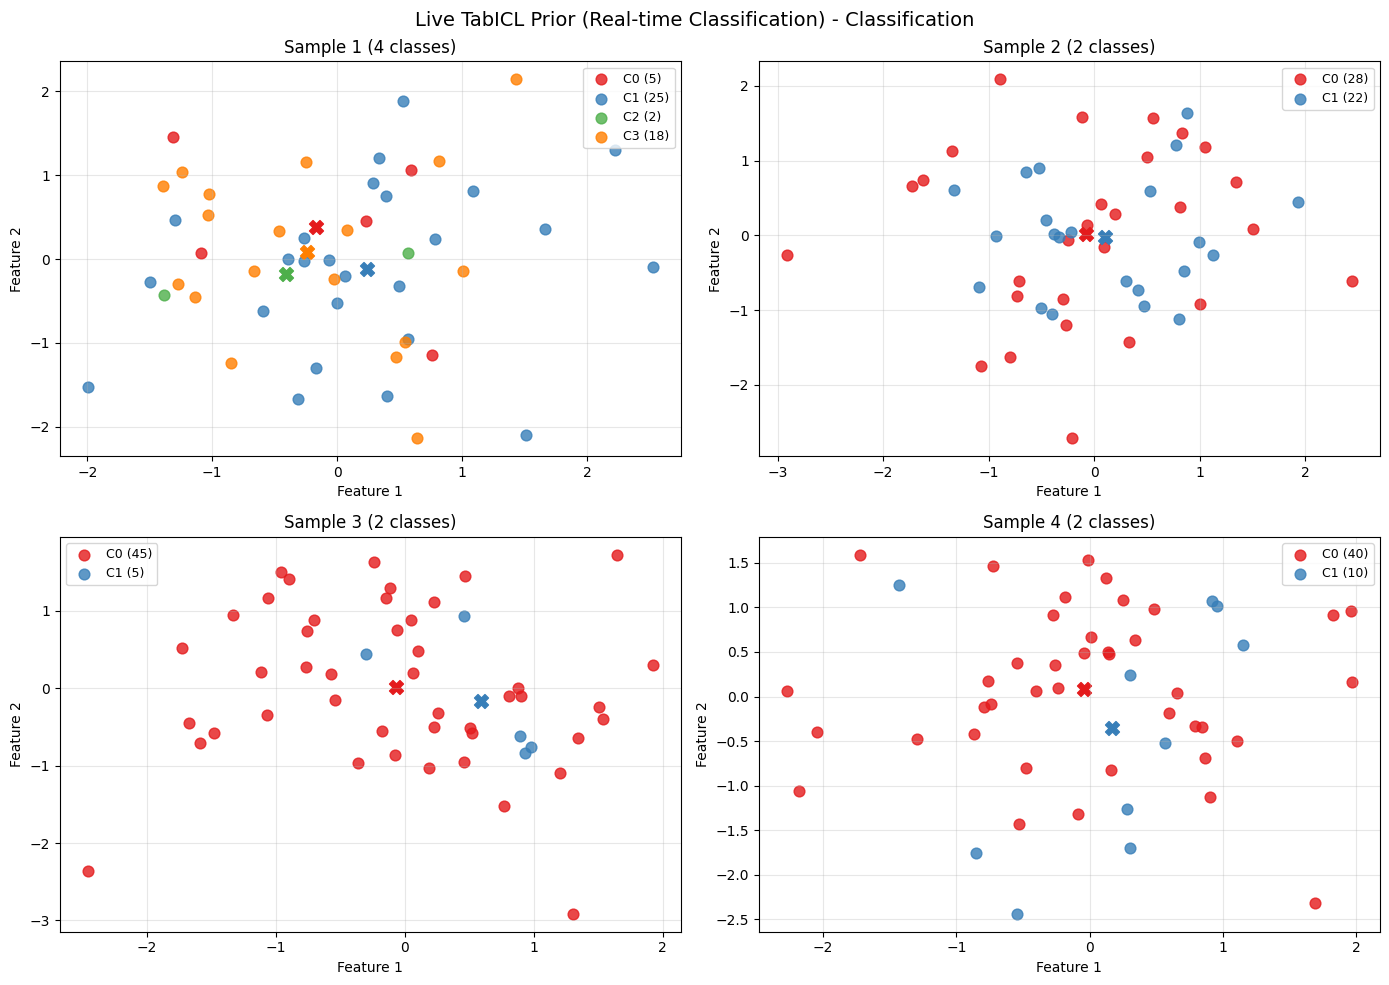

In [10]:
# Live TabICL classification data generation
from tfmplayground.priors.dataloader import TabICLPriorDataLoader

tabicl_live_loader = TabICLPriorDataLoader(
    num_steps=1,
    batch_size=4,
    num_datapoints_min=None,
    num_datapoints_max=50,
    min_features=2,
    max_features=2,
    max_num_classes=5,
    device=device
)

X_live_tabicl, y_live_tabicl, _ = load_and_print_info(tabicl_live_loader, "live")

plot_classification_samples(
    X_data=X_live_tabicl, 
    y_data=y_live_tabicl, 
    title="Live TabICL Prior (Real-time Classification)"
)